In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sys import version
import model
import importlib

print(f"Python: {version}")
print(f"  >      numpy: {np.__version__}")
print(f"  > matplotlib: {mpl.__version__}")

Python: 3.12.8 (main, Dec  3 2024, 18:42:41) [GCC 14.2.1 20241116]
  >      numpy: 2.2.2
  > matplotlib: 3.10.0


In [85]:
importlib.reload(model)
np.random.seed(69)

N_gpe, N_stn = 8, 8
dt = 0.01
I_app = lambda t, n: -1.

c_G_S = np.zeros((N_gpe, N_stn), dtype=np.bool)
c_S_G = np.zeros((N_stn, N_gpe), dtype=np.bool)
c_G_G = ~np.eye(N_gpe, dtype=np.bool)

for idx_g in range(N_gpe):
    ids_s = np.random.choice(np.arange(N_stn), size=3, replace=False)
    c_G_S[idx_g, ids_s] = 1

c_S_G[np.arange(N_stn), np.random.permutation(N_gpe)] = 1

c_G_S = np.zeros((N_gpe, N_stn), dtype=np.bool)
c_S_G = np.eye(N_stn, dtype=np.bool)
c_G_G = np.zeros((N_gpe,N_gpe), dtype=np.bool)

c_G_G[0,[1,-1]] = 1
for i in range(0,N_gpe-1):
    c_G_G[i+1] = np.roll(c_G_G[i], 1)
c_G_S[0,[2,-2]] = 1
for i in range(0,N_gpe-1):
    c_G_S[i+1] = np.roll(c_G_S[i], 1)

# print("GPe -> STN")
# print(c_G_S.astype(np.int8))

# print("\nSTN -> GPe")
# print(c_S_G.astype(np.int8))


data = model.rubin_terman(N_gpe, N_stn, I_app_gpe=I_app, dt=dt, T=2, 
                          c_G_S=c_G_S, c_G_G=c_G_G, c_S_G=c_S_G)
print(list(data.keys()))

['I_L_stn', 'I_K_stn', 'I_Na_stn', 'I_T_stn', 'I_Ca_stn', 'I_AHP_stn', 'I_ext_stn', 'Ca_stn', 'v_stn', 'I_L_gpe', 'I_K_gpe', 'I_Na_gpe', 'I_T_gpe', 'I_Ca_gpe', 'I_AHP_gpe', 'I_ext_gpe', 'I_app_gpe', 'Ca_gpe', 'v_gpe', 'I_G_S', 'I_G_G', 'I_S_G', 's_stn', 's_gpe']


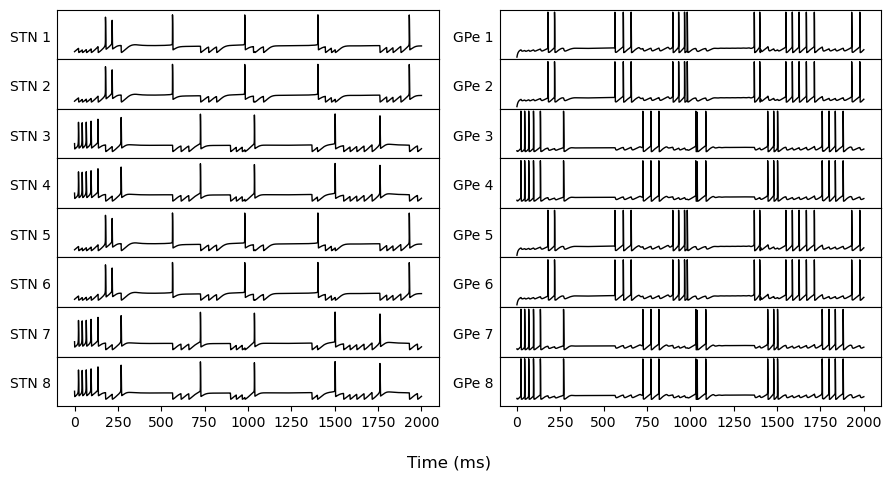

In [86]:
fig, axs = plt.subplots(N_stn, 2, figsize=(9, (N_stn)*0.6), 
                            sharex=True, sharey=True, tight_layout=True, gridspec_kw={'hspace': 0})

for i, (trace, ax) in enumerate(zip(data["v_stn"].T, axs[:,0])):
    ax.plot(trace, 'k', lw=1)
    ax.set_yticks([])
    ax.set_ylabel(f"STN {i+1}", rotation=0, labelpad=10)
    ax.yaxis.set_label_coords(-0.07, 0.3)
    
for i, (trace, ax) in enumerate(zip(data["v_gpe"].T, axs[:, 1])):
    ax.plot(trace, 'k', lw=1)
    ax.set_yticks([])
    ax.set_ylabel(f"GPe {i+1}", rotation=0, labelpad=10)
    ax.yaxis.set_label_coords(-0.07, 0.3)

axs[-1,0].xaxis.set_major_formatter(lambda x, _: f"{x*0.01:.0f}")

fig.supxlabel("Time (ms)")
    
plt.show()

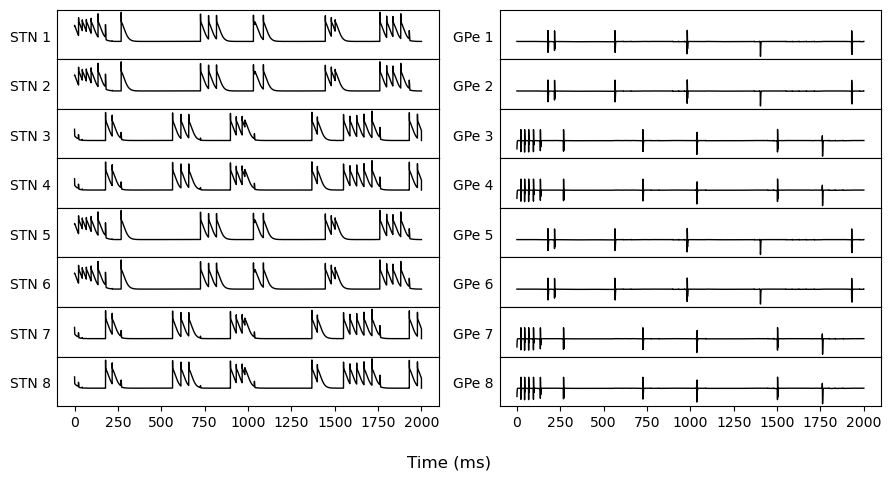

In [83]:
fig, axs = plt.subplots(N_stn, 2, figsize=(9, (N_stn)*0.6), 
                            sharex=True, sharey=True, tight_layout=True, gridspec_kw={'hspace': 0})

for i, (trace, ax) in enumerate(zip(data["I_G_S"].T, axs[:,0])):
    ax.plot(trace, 'k', lw=1)
    ax.set_yticks([])
    ax.set_ylabel(f"STN {i+1}", rotation=0, labelpad=10)
    ax.yaxis.set_label_coords(-0.07, 0.3)
    
for i, (trace, ax) in enumerate(zip(data["I_S_G"].T, axs[:, 1])):
    ax.plot(trace, 'k', lw=1)
    ax.set_yticks([])
    ax.set_ylabel(f"GPe {i+1}", rotation=0, labelpad=10)
    ax.yaxis.set_label_coords(-0.07, 0.3)

axs[-1,0].xaxis.set_major_formatter(lambda x, _: f"{x*0.01:.0f}")

fig.supxlabel("Time (ms)")
    
plt.show()

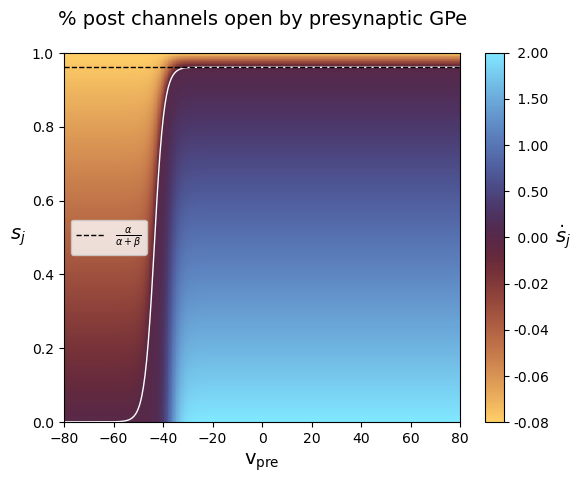

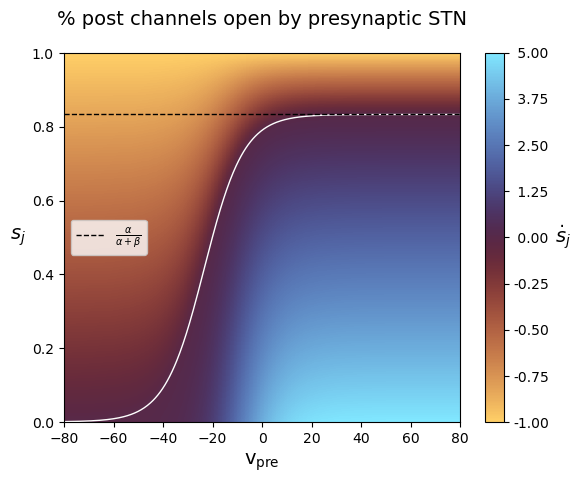

In [66]:
a = np.array([2.  , 5.])
b = np.array([ .08, 1.])
theta_g  = np.array([ 20.,  30.])
theta_gH = np.array([-57., -39.])
sigma_gH = np.array([  2.,   8.])
pre_type = ["GPe", "STN"]

y1=np.linspace(-80, 80, 500)
y2=np.linspace(-0 , 1 , 500)
X,Y=np.meshgrid(y1,y2)

for a, b, theta_g, theta_gH, sigma_gH, pre_type in zip(a, b, theta_g, theta_gH, sigma_gH, pre_type):
    H_inf = lambda v: 1 / (1 + np.exp(-(v - theta_gH)/sigma_gH))
    sj_inf = a * H_inf(y1 - theta_g) / (a * H_inf(y1 - theta_g) + b)
    
    
    v = a * H_inf(y1[None,:] - theta_g) * (1 - y2[:,None]) - b *y2[:,None]

    vmin, vmax = v.min(), v.max()
    norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    pcm = plt.pcolormesh(X, Y, v, cmap="managua", norm=norm, shading="auto")
    ticks = np.concatenate((np.linspace(vmin, 0, 5), np.linspace(0, vmax, 5)[1:]))
    cbar = plt.colorbar(pcm, ticks=ticks, 
                 format=lambda x, _: f"{x:.2f}" if x < 0 else f" {x:.2f}")
    cbar.set_label(r"$\dot s_j$", rotation=0, fontsize=14, labelpad=10, va='center')
    plt.plot(y1, sj_inf, "w", lw=1)
    plt.plot(y1, np.ones_like(y1) * a / (a + b), "k--", lw=1, label=r"$\frac{\alpha}{\alpha + \beta}$")
    plt.title(f"% post channels open by presynaptic {pre_type}", fontsize=14, pad=20)
    plt.xlabel(r"$\rm{v_{pre}}$", fontsize=14)
    plt.ylabel("$s_j$", rotation=0, fontsize=14, labelpad=10, va='center')
    plt.legend(loc="center left")
    plt.savefig(f"syn_pre_{pre_type}.png")
    plt.show()